# VAR Model: energy prices and inflation
We assume a relationship between the energy prices and inflation. We model such relationship in order to predict a variation of inflation from a variation of the energy prices. We use the prices of natural gas and the inflation for Italy from January 2016 to December 2023. For the energy price we use the data for the natural gas from the International Monetary Fund (IMF). From the [IMF website](https://data.imf.org/?sk=471dddf8-d8a7-499a-81ba-5b332c01f8b9) we select the Natural Gas Netherlands TFF dataset as the commodity in US dollars. For the inflation we use the general index for Italy from [ISTAT](http://dati.istat.it/). Since the energy prices can affect the inflation and, vice versa, the inflation can affect the energy prices, we use the vector autoregressive (VAR) model to represent the processes and their interaction. The VAR model is an extension of the autoregressive model AR(p). 

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import dates
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from osgeo import gdal, osr, ogr
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("Python version: %s"%python_version())
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print('GDAL version: %s'%gdal.__version__)
print("GeoPandas version: %s"%gpd.__version__)

Python version: 3.11.5
NumPy version: 1.25.2
Pandas version: 2.1.1
GDAL version: 3.7.2
GeoPandas version: 0.14.0


## Natural Gas - Netherlands TFF

In [2]:
imf_commodities_path = 'data/imf_commodities.csv'
imf_commodities_tmp = pd.read_csv(imf_commodities_path)
imf_commodities_tmp.head(2)

,Country Name,Country Code,Commodity Name,Commodity Code,Unit Name,Unit Code,Attribute,2015M1,2015M2,2015M3,...,2023M4,2023M5,2023M6,2023M7,2023M8,2023M9,2023M10,2023M11,2023M12,Unnamed: 115
0,World,1,Industrial Materials index,PINDU,Index,IX,Value,115.697669,112.891399,110.187288,...,168.360791,156.684029,156.434364,157.406576,154.700611,159.823049,157.575786,163.444974,165.612251,NaN
1,World,1,Non-Fuel index,PNFUEL,Index,IX,Value,108.401507,105.827424,102.837085,...,155.829121,148.774443,145.943374,146.109110,142.639895,143.647360,143.546099,148.093495,148.636510,NaN


In [3]:
natural_gas_tmp = imf_commodities_tmp[(imf_commodities_tmp['Commodity Code'] == 'PNGAS') & (imf_commodities_tmp['Unit Code'] == 'IX')]
nat_gas_values = natural_gas_tmp.loc[natural_gas_tmp.index, '2016M1':'2023M12'].values[0]

In [4]:
month_index = pd.date_range('2016-01-01', '2024-01-01', freq='M')

In [5]:
len(month_index)

96

In [7]:
nat_gas_df = pd.DataFrame({'Price': nat_gas_values}, index=month_index)
nat_gas_df.shape

(96, 1)

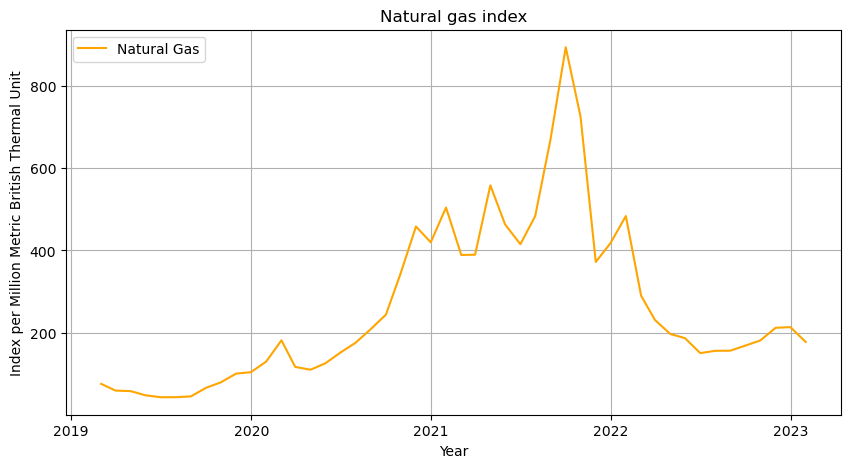

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Natural gas index")
ax.set_xlabel("Year")
ax.set_ylabel("Index per Million Metric British Thermal Unit");
ax.set_xticks(month_index)
#ax.set_xticklabels(month_index, rotation=70)
#ax.set_yticks(np.arange(0, 60, 2), minor=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(dates.MonthLocator(12))
ax.grid(True)
ax.plot(nat_gas_df['2020':'2023'], label='Natural Gas', color='orange')
plt.legend(loc='upper left')

## Inflation

In [9]:
inflation_italy_path = 'data/istat_indice_prezzi_al_consumo_nic.csv'
inflation_italy_tmp = pd.read_csv(inflation_italy_path, usecols=['TIME', 'Value', 'Misura'])
inflation_italy_num_indici = inflation_italy_tmp[inflation_italy_tmp['Misura'] == 'numeri indici'][['TIME', 'Value']]
inflation_italy_num_indici.head(2)

,TIME,Value
0,2016-01,99.6
1,2016-02,99.4


In [14]:
inflation_df = pd.DataFrame({'Index': inflation_italy_num_indici['Value'].to_list()}, index=month_index)
inflation_df.shape

(96, 1)

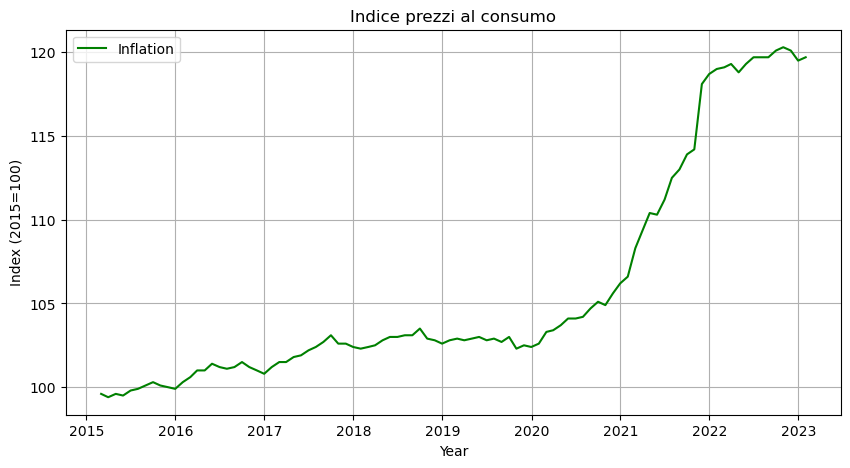

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Indice prezzi al consumo")
ax.set_xlabel("Year")
ax.set_ylabel("Index (2015=100)");
ax.set_xticks(month_index)
#ax.set_xticklabels(month_index, rotation=70)
#ax.set_yticks(np.arange(0, 60, 2), minor=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(dates.MonthLocator(12))
ax.grid(True)
ax.plot(inflation_df, label='Inflation', color='green')
plt.legend(loc='upper left')
plt.savefig('inflation_italy_2016_2023')

## The VAR model
In an autoregressive process the output variable $y_t$ depends linearly on its previous values

$$y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + .. + \phi_p y_{t-p} + \epsilon_t$$

where $\delta$ is a constant and $\epsilon_t$ an error term. The index p represents the order of the autoregressive process AR(p), that is the number of previous values that are taken into account to predict the actual value of the output. For example, the output variable of an autoregressive process of order 1 is represented by

$$y_t = \delta + \phi_1 y_{t-1} + \epsilon_t$$

We can represent a process of two variables with an AR model adding for each variable its dependency on the other. For a model of order 1, i.e. p=1, we can represent the system of two variables 

$$y_{1,t} = \delta_1 + \phi_{1, 1} y_{1, t-1} + + \phi_{1, 2} y_{2, t-1} + \epsilon_{1, t}$$
$$y_{2,t} = \delta_2 + \phi_{2, 1} y_{1, t-1} + + \phi_{2, 2} y_{2, t-1} + \epsilon_{2, t}$$

or in matrix form

$$\begin{bmatrix} y_{1,t} \\ y_{2,t} \end{bmatrix} = \begin{bmatrix} \delta_1 \\ \delta_2 \end{bmatrix} + \begin{bmatrix} \phi_{1, 1} & \phi_{1, 2} \\ \phi_{2, 1} & \phi_{2, 2} \end{bmatrix} \begin{bmatrix} y_{1, t-1} \\ y_{2,t-1} \end{bmatrix} + \begin{bmatrix} \epsilon_{1, t} \\ \epsilon_{2, t} \end{bmatrix}$$

If we include a dependency of p past values the system of equations becomes

$$\begin{bmatrix} y_{1,t} \\ y_{2,t} \end{bmatrix} = \begin{bmatrix} \delta_1 \\ \delta_2 \end{bmatrix} + \begin{bmatrix} \phi_{1, 1} & \phi_{1, 2} \\ \phi_{2, 1} & \phi_{2, 2} \end{bmatrix} \begin{bmatrix} y_{1, t-1} \\ y_{2,t-1} \end{bmatrix} + .. + \begin{bmatrix} \phi_{1, 1}^{(p)} & \phi_{1, 2}^{(p)} \\ \phi_{2, 1}^{(p)} & \phi_{2, 2}^{(p)} \end{bmatrix} \begin{bmatrix} y_{1, t-p} \\ y_{2,t-p} \end{bmatrix} + \begin{bmatrix} \epsilon_{1, t} \\ \epsilon_{2, t} \end{bmatrix}$$


## Modeling workflow
1. We test the stationarity of the two time series using the augmented Dickey-Fuller (ADF) test. At the end of the test we have the order p of the VAR(p) model or the number of time lags that we have to consider to have a stationary time series
2. We select the VAR(p) model with the lowest Akaike Information Criterion ([AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)).
3. We test the stationary time series for the Granger causality in both direction, in other words we test that $y_1$ depends on $y_2$ and vice versa
4. We perform an analysis of the residuals 

### 1. Stationarity test
We perform the Augmented Dickey–Fuller ([ADF](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)) test for the stationarity of the two time series: the consumer price index (cpi), and the natural gas price (ngp). The test assumes as the null hyphothesis that the time series is non-stationary. The non-stationarity of the two time series can be seen from the plots but we perform the statistical test nontheless.

In [15]:
ad_fuller_cpi = adfuller(inflation_df['Index'])

print('Inflation')
print(f'ADF Statistic: {ad_fuller_cpi[0]}')
print(f'p-value: {ad_fuller_cpi[1]}')

Inflation
ADF Statistic: 0.6874245997068185
p-value: 0.9895835356470782


In [16]:
ad_fuller_ngp = adfuller(nat_gas_df['Price'])

print('Natural Gas Price')
print(f'ADF Statistic: {ad_fuller_ngp[0]}')
print(f'p-value: {ad_fuller_ngp[1]}')

Natural Gas Price
ADF Statistic: -1.8580196334983037
p-value: 0.3520602148691576


The p-values of the tests is greater than 0.05 so we cannot reject the null hypothesis that the two series are non-stationary as we already knew. We apply a simple transformation, subtracting the previous value from each value in the series, then we test the transformed series for stationarity 

In [18]:
ad_fuller_cpi = adfuller(inflation_df['Index'].diff()[1:])

print('Inflation')
print(f'ADF Statistic: {ad_fuller_cpi[0]}')
print(f'p-value: {ad_fuller_cpi[1]}')

Inflation
ADF Statistic: -2.8030329466839605
p-value: 0.05784183755571429


In [19]:
ad_fuller_ngp = adfuller(nat_gas_df['Price'].diff()[1:])

print('Natural Gas Price')
print(f'ADF Statistic: {ad_fuller_ngp[0]}')
print(f'p-value: {ad_fuller_ngp[1]}')

Natural Gas Price
ADF Statistic: -3.930084691468701
p-value: 0.0018242644322370963


The p-value for the transformed natural gas price time series is lower than 0.05 so we can reject the null hypothesis and assume that it is stationary. The p-value for the transformed consumer price index is a little bit greater than 0.05 so we could not reject the null hypothesis but since the difference is very small we reject the null hypothesis assuming the transformed time series is stationary.

### 2. VAR(p) model selection
Now we have to select the VAR(p) model that consist of assessing the order p of the dependency of the variables from the past values. e will select the model with the smallest AIC value.

In [20]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.varmax import VARMAX

def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:
    
    results = []
    
    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        aic = model.aic
        results.append([i, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [24]:
endog = pd.DataFrame({'Inflation': inflation_df['Index'].values, 'NG price': nat_gas_df['Price'].values})
endog.head(2)

,Inflation,NG price
0,99.6,106.033113
1,99.4,97.687611


In [25]:
endog_diff = endog.diff()[1:]
endog_diff.head(2)

,Inflation,NG price
1,-0.2,-8.345502
2,0.2,-6.809441


In [27]:
endog.shape, endog_diff.shape

((96, 2), (95, 2))

We can see that the best model is the one that requires 13 past values (p = 13)

In [28]:
train_test_split_index = 80
train = endog_diff[:train_test_split_index]
test = endog_diff[train_test_split_index:]
result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,AIC
0,13,839.755721
1,12,842.237622
2,11,856.013334
3,10,870.878676
4,7,878.408818
5,5,881.084261
6,8,881.345811
7,9,881.986284
8,6,883.899860
9,3,906.199003


In [48]:
order = result_df['p'][0]
order

13

### 3. Granger causality test
We perform two Granger-causality tests: one to assess whether inflation Granger-causes the natural gas price, and a second test to assess whether the natural gas price causes inflation. The null hypothesis of the Granger causality test is that the variables being tested do not cause each other. 

In [49]:
from statsmodels.tsa.stattools import grangercausalitytests

print('Inflation Granger-causes natural gas price?\n')
print('------------------')
granger_cpi_ngp = grangercausalitytests(endog_diff, [order])

Inflation Granger-causes natural gas price?

------------------

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=11.1984 , p=0.0000  , df_denom=55, df_num=13
ssr based chi2 test:   chi2=217.0446, p=0.0000  , df=13
likelihood ratio test: chi2=106.0976, p=0.0000  , df=13
parameter F test:         F=11.1984 , p=0.0000  , df_denom=55, df_num=13


In [34]:
endog_diff_t = endog_diff[['NG price', 'Inflation']] # changed columns order 

In [50]:
print('\nNatural gas price Granger-causes inflation?\n')
print('------------------')
granger_2 = grangercausalitytests(endog_diff_t, [order])


Natural gas price Granger-causes inflation?

------------------

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=2.6299  , p=0.0064  , df_denom=55, df_num=13
ssr based chi2 test:   chi2=50.9727 , p=0.0000  , df=13
likelihood ratio test: chi2=39.6408 , p=0.0002  , df=13
parameter F test:         F=2.6299  , p=0.0064  , df_denom=55, df_num=13


Since both tests return p-values lower than 0.05 we can reject the null hypothesis and conclude that one causes the other.

### 4. Residual analysis
We fit our best model (p=13)

In [51]:
best_model = VARMAX(train, order=(order,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               Statespace Model Results                              
Dep. Variable:     ['Inflation', 'NG price']   No. Observations:                   80
Model:                               VAR(13)   Log Likelihood                -362.878
                                 + intercept   AIC                            839.756
Date:                       Thu, 18 Apr 2024   BIC                            975.531
Time:                               14:12:00   HQIC                           894.192
Sample:                                    0                                         
                                        - 80                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):             0.12, 0.17   Jarque-Bera (JB):          0.61, 64.33
Prob(Q):                        0.73, 0.68   Prob(JB):                   0.74, 0.00
Heteroskedasticity (H):         0.87, 6.81   Skew:        

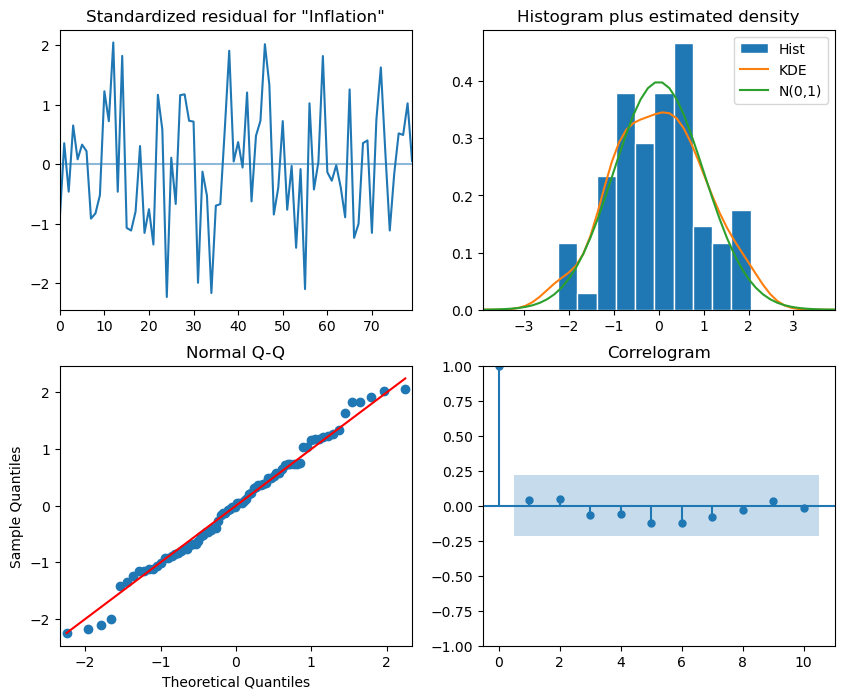

In [52]:
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

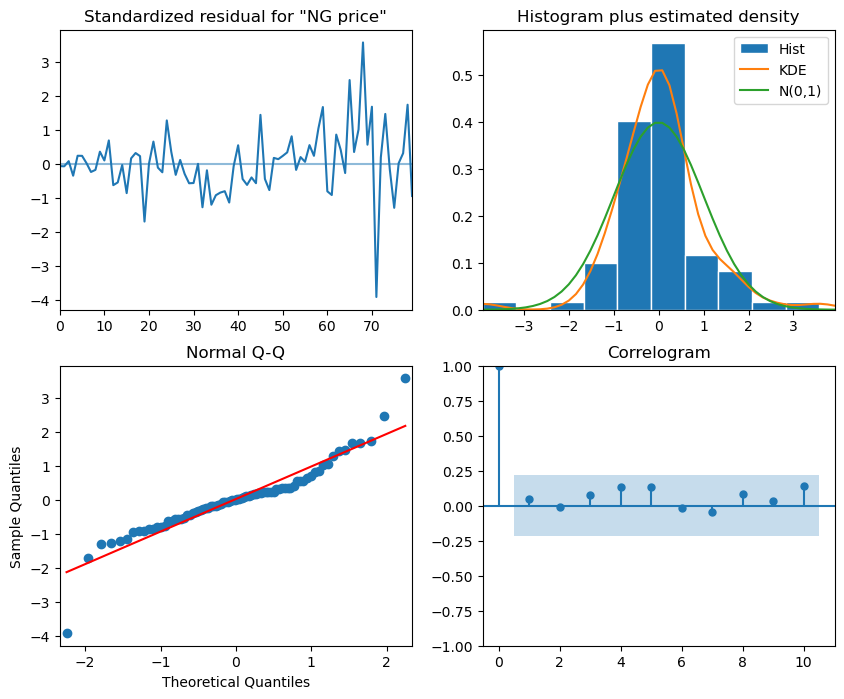

In [53]:
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

We perform the Ljung-Box test to assess whether the residuals for inflation and natural gas prices are independent and uncorrelated. The null hypothesis is that the residuals for inflation and the natural gas price are independent and uncorrelated so if we get p-values < 0.05 we reaject it and if we get p-values > 0.05 we cannot reject it.

In [41]:
from statsmodels.stats.diagnostic import acorr_ljungbox

inflation_residuals = best_model_fit.resid['Inflation']

lbvalue, pvalue = acorr_ljungbox(inflation_residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [45]:
ngprice_residuals = best_model_fit.resid['NG price']

lbvalue, pvalue = acorr_ljungbox(ngprice_residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


## Model forecasts

In [58]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str, order: int) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VAR':

        inflation_pred_VAR = []
        ng_price_pred_VAR = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(order,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_inflation = predictions.predicted_mean.iloc[-window:]['Inflation']
            oos_pred_ng_price = predictions.predicted_mean.iloc[-window:]['NG price']
            
            inflation_pred_VAR.extend(oos_pred_inflation)
            ng_price_pred_VAR.extend(oos_pred_ng_price)
        
        return inflation_pred_VAR, ng_price_pred_VAR
    
    elif method == 'last':
        inflation_pred_last = []
        ng_price_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            inflation_last = df[:i].iloc[-1]['Inflation']
            ng_price_last = df[:i].iloc[-1]['NG price']
            
            inflation_pred_last.extend(inflation_last for _ in range(window))
            ng_price_pred_last.extend(ng_price_last for _ in range(window))
            
        return inflation_pred_last, ng_price_pred_last

In [59]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

inflation_pred_VAR, ng_price_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR', order)

In [60]:
test = endog[train_test_split_index:]

test['inflation_pred_VAR'] = pd.Series()
test['inflation_pred_VAR'] = endog.iloc[train_test_split_index - 1]['Inflation'] + np.cumsum(inflation_pred_VAR)

test['ng_price_pred_VAR'] = pd.Series()
test['ng_price_pred_VAR'] = endog.iloc[train_test_split_index - 1]['NG price'] + np.cumsum(ng_price_pred_VAR)

test

,Inflation,NG price,inflation_pred_VAR,ng_price_pred_VAR
80,114.2,725.030422,114.820705,879.142903
81,118.1,372.159727,116.281857,1042.642005
82,118.7,418.041281,116.691434,1069.135301
83,119.0,483.499418,118.181385,1036.415988
84,119.1,290.286367,118.981951,838.647263
85,119.3,231.518007,121.142282,780.445705
86,118.8,197.485761,120.103103,1088.259254
87,119.3,187.266901,119.102013,1330.094673
88,119.7,150.936606,119.245059,1094.932592
89,119.7,156.480575,117.991857,1122.144488


In [61]:
inflation_pred_last, ng_price_pred_last = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'last', order)

test['inflation_pred_last'] = inflation_pred_last
test['ng_price_pred_last'] = ng_price_pred_last

test

,Inflation,NG price,inflation_pred_VAR,ng_price_pred_VAR,inflation_pred_last,ng_price_pred_last
80,114.2,725.030422,114.820705,879.142903,0.3,-168.071429
81,118.1,372.159727,116.281857,1042.642005,0.3,-168.071429
82,118.7,418.041281,116.691434,1069.135301,0.3,-168.071429
83,119.0,483.499418,118.181385,1036.415988,0.3,-168.071429
84,119.1,290.286367,118.981951,838.647263,0.1,-193.213051
85,119.3,231.518007,121.142282,780.445705,0.1,-193.213051
86,118.8,197.485761,120.103103,1088.259254,0.1,-193.213051
87,119.3,187.266901,119.102013,1330.094673,0.1,-193.213051
88,119.7,150.936606,119.245059,1094.932592,0.4,-36.330296
89,119.7,156.480575,117.991857,1122.144488,0.4,-36.330296


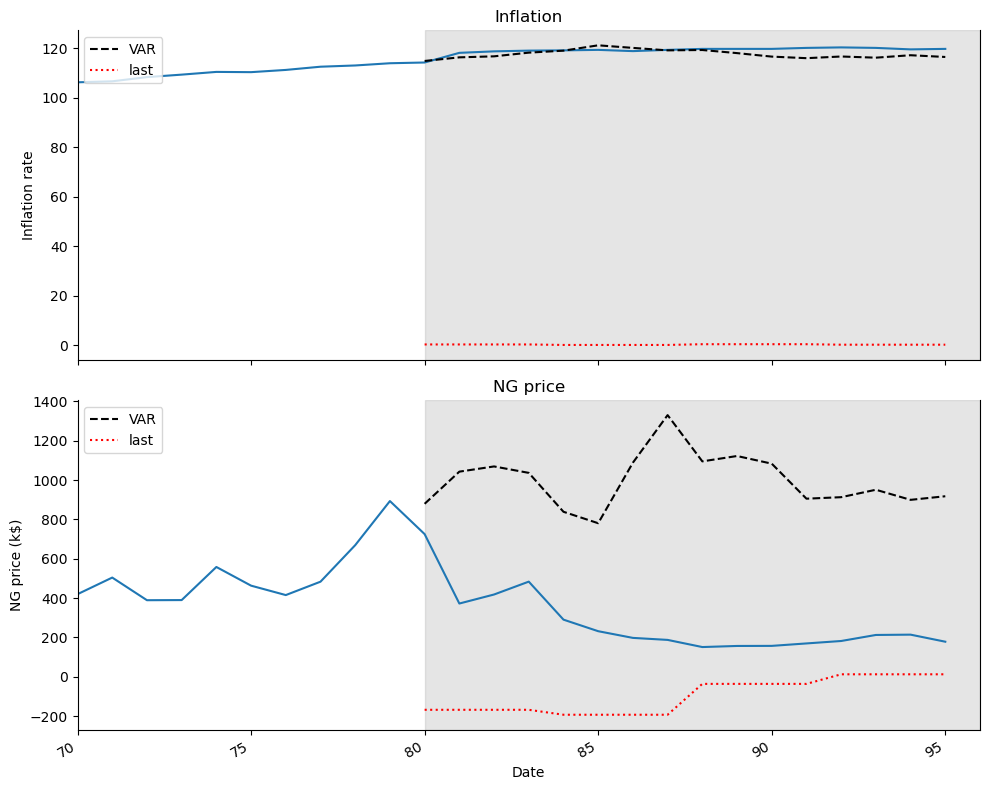

In [64]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(endog['Inflation'])
ax1.plot(test['inflation_pred_VAR'], 'k--', label='VAR')
ax1.plot(test['inflation_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Inflation rate')
ax1.set_title('Inflation')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(train_test_split_index, endog.shape[0], color='#808080', alpha=0.2)
ax1.set_xlim(70, endog.shape[0])
ax1.legend(loc=2)

ax2.plot(endog['NG price'])
ax2.plot(test['ng_price_pred_VAR'], 'k--', label='VAR')
ax2.plot(test['ng_price_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('NG price (k$)')
ax2.set_title('NG price')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(train_test_split_index, endog.shape[0], color='#808080', alpha=0.2)
ax2.set_xlim(70, endog.shape[0])
ax2.legend(loc=2)

#plt.xticks(np.arange(0, endog.shape[0], 16), np.arange(1959, 2010, 4))
plt.xlim(70, endog.shape[0])

fig.autofmt_xdate()
plt.tight_layout()

In [65]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [66]:
mape_inflation_VAR = mape(test['Inflation'], test['inflation_pred_VAR'])
mape_inflation_last = mape(test['Inflation'], test['inflation_pred_last'])

mape_ng_price_VAR = mape(test['NG price'], test['ng_price_pred_VAR'])
mape_ng_price_last = mape(test['NG price'], test['ng_price_pred_last'])

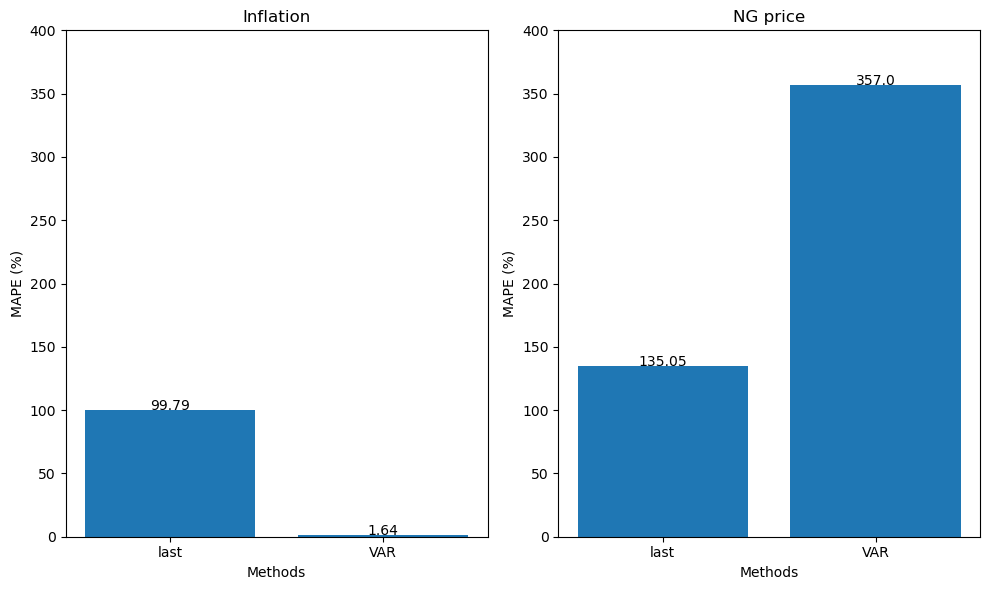

In [68]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR']
y1 = [mape_inflation_last, mape_inflation_VAR]
y2 = [mape_ng_price_last, mape_ng_price_VAR]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('Inflation')
ax1.set_ylim(0, 400)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('NG price')
ax2.set_ylim(0, 400)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()
